In [2]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys

from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from information_scores import *
import os
import scipy.io
import pandas as pd
from scipy.io import loadmat
from pathlib import Path
import math
from scipy.misc import derivative
from scipy import signal
from sklearn.linear_model import Lasso

In [3]:
# Loading DATA
train_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-08-19-16-02_5sec.mat"
train_file2 = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)
test_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [31]:
# SINDy Function Definitions

def build_library(X,Y):
    
    # obtain size of state space
    l = X.shape[0]
    n = X.shape[1]
    m = Y.shape[1]
    
    # add in a constant by making a column of ones
    Theta = np.ones((l,1))
    function_label = ['1']
    
    # add in first order polynomials of all the states
    for i in range(n):
        state = np.array([X[:,i]]).T
        Theta = np.append(Theta,state,axis=1)
        function_label.append('x'+str(i))
    
    # add in sines of all states 
    for i in range(n):
        sine_state = np.array([np.sin(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('sin x'+str(i))
        
    # add in cosines of all states  
    for i in range(n):
        sine_state = np.array([np.cos(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('cos x'+str(i))
        
    # add in tangents of all states  
    for i in range(n):
        sine_state = np.array([np.tan(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('tan x'+str(i))
        
    
    # add in controls
    for i in range(m):
        control = np.array([Y[:,i]]).T
        Theta = np.append(Theta,control,axis=1) 
        function_label.append('u'+str(i))
 
    return Theta,function_label

# def Sparse_Regression(Theta,dXdt,thresh):
    
#     lassoreg = Lasso(alpha=thresh,normalize=True, max_iter=1e5) # sparsify!!!!! Hell yeah!!!
#     lassoreg.fit(Theta,dXdt)
#     Xi = lassoreg.coef_
    
#     return Xi.T


def Sparse_Regression(Theta,dXdt,thresh):
    
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    smallinds = np.where(np.abs(Xi) < thresh) # find where the entries is Xi are below the threshold
    Xi[smallinds] = 0 # sparsify!!!!! Hell yeah!!!
    
    return Xi


In [53]:
dt = 0.01 # sampling time in seconds

X = train_state_traj2.T
Y = train_action_traj2.T
dX = np.zeros((X.shape[0]-4))

for i in range(X.shape[1]):
    Xi = X[:,i]
    dXi = (1/(12*dt)) * (-Xi[4:] + 8*Xi[3:-1] - 8*Xi[1:-3] + Xi[:-4])
    Xi = Xi[2:-2]
    dX = np.vstack([dX,dXi])

Y = Y[2:-2,:]
X = X[2:-2,:]
Xprime = dX[1:,:].T


print(Y.shape,X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

Theta,function_label = build_library(X,Y) # build the lbrary of functions (Theta)
threshold = .1 # thresholding paramater for sparsification
Xi = Sparse_Regression(Theta,Xprime,threshold) # obtain Xi ("ksi") that gives us the coefficients
print(Xi.shape)

(1052, 3) (1052, 9) (1052, 9)
(40, 9)


In [54]:
df = pd.DataFrame(Xi,index = function_label)
A=df.head(40)

In [55]:
A


,0,1,2,3,4,5,6,7,8
1,22.971026,-130.034720,-138.628402,86.645404,-2.432201,-4.961017e+02,7.431535e+03,1.362896e+03,-1.465520e+03
x0,-43503.957219,-61502.588074,52682.708942,36058.456210,-212198.717599,-2.419466e+06,3.254408e+06,-7.505883e+06,3.051851e+06
x1,-3362.136805,473.541517,-23554.170001,24864.975535,5528.046602,4.835594e+04,1.306688e+06,2.393433e+05,7.400681e+02
x2,655.489540,-2046.763075,-2433.965057,2188.594559,490.798361,-4.893384e+02,1.533632e+05,1.800205e+04,-9.853544e+03
x3,1.624370,6.732054,3.777532,-6.369917,9.913528,-6.370188e+01,1.732944e+03,4.143327e+02,-2.172964e+02
x4,3318.708836,-2308.624277,302.778143,795.620928,-443.872716,-2.988367e+03,-6.363037e+04,-3.962303e+04,8.428656e+03
x5,0.000000,0.000000,-0.261242,0.000000,0.000000,-1.181364e+00,1.424673e+01,-1.249478e+00,-9.651497e-01
x6,0.000000,0.240675,-0.721575,1.238838,0.000000,-8.434173e-01,3.974562e+01,7.098260e+00,-7.364452e-01
x7,0.000000,0.139569,-0.374281,0.350731,1.105219,2.318033e+00,3.458518e+01,2.201727e+01,-4.090116e-01
x8,0.000000,0.000000,0.132961,0.000000,0.000000,-4.519649e-01,-1.012116e+01,-3.797860e+00,1.672976e+00


In [58]:
C= np.zeros((40,9))
for j in range(9):
    for iter1,i in enumerate(A[j]):
        C[iter1,j]= i
    


In [59]:
def evolution(states,time,u):
    u0= u[0];u1= u[1];u2= u[2];
    x0= states[0];x1= states[1];x2=states[2];x3= states[3];x4= states[4];x5=states[5];x6= states[6];x7= states[7];x8=states[8]
    assump= np.array([1,x0 ,x1,x2 ,x3,x4,x5,x6,x7,x8, np.sin(x0),np.sin(x1),np.sin(x2),np.sin(x3),np.sin(x4),np.sin(x5),\
 np.sin (x6),np.sin(x7),np.sin(x8),np.cos(x0),np.cos(x1),np.cos(x2),np.cos(x3),np.cos(x4),np.cos(x5),np.cos(x6),\
np.cos (x7),np.cos(x8),np.tan(x0),np.tan(x1),np.tan(x2),np.tan(x3),np.tan(x4),np.tan(x5),np.tan(x6),np.tan(x7),np.tan(x8),\
u0,u1,u2])
    x_dot=C.T@assump
    return x_dot
                    
def simulate_traj(time_range,u_traj,init_state):
    print(u_traj.shape)
    predicted_traj= []
    current_state= init_state.copy()
    for iter1,i in enumerate(time_range[:-1]):
        next_time= time_range[iter1+1]
        u= u_traj[:,iter1]
        #integrate_time= np.linspace(i,next_time,100)
        sol = odeint(evolution, current_state, [i,i+0.01], args=(u,))
        current_state = sol[-1]
        predicted_traj.append(current_state)
    return predicted_traj
        
    

In [60]:


pred_traj=simulate_traj(time_range, test_action_traj, test_state_traj[:,0])

(3, 756)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [56]:
pred_traj= np.asarray(pred_traj)
pred_traj= pred_traj.T

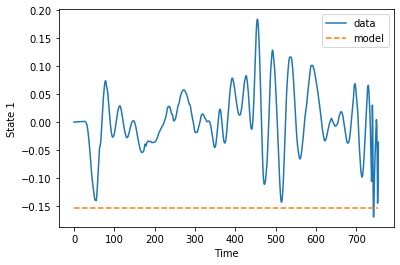

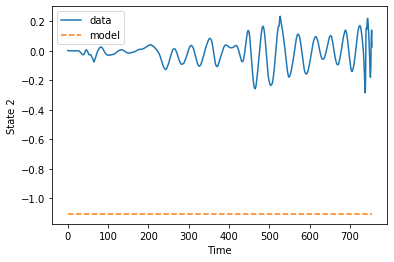

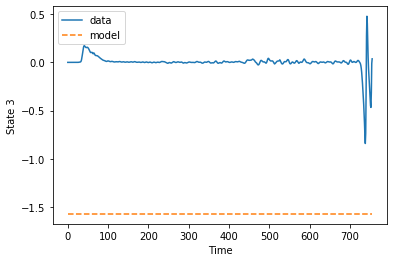

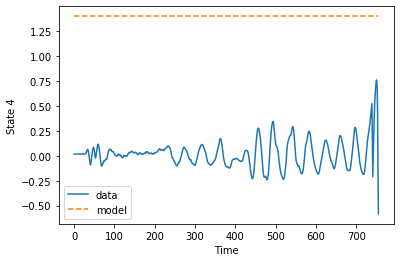

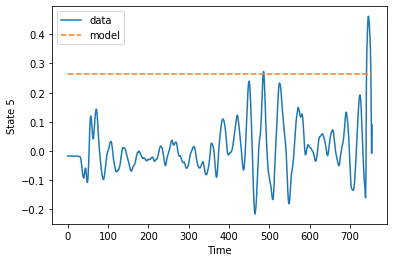

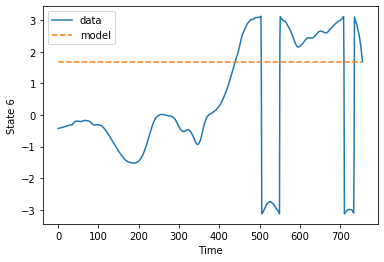

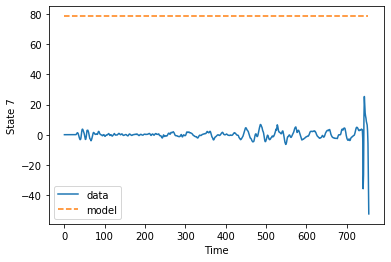

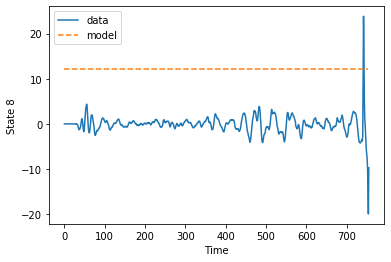

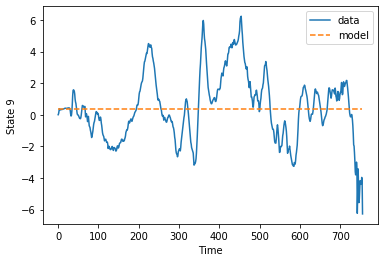

In [57]:

for i in range(9):
    plt.plot(test_state_traj[i,:],label ='data')
    plt.plot(pred_traj[i,:],label = 'model', linestyle='--')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State '+str(i+1))
    plt.show()

In [21]:
pred_traj.shape

(9, 755)